In [ ]:

!pip uninstall -y monai monai-weekly monai-generative
!pip install -q monai-generative lpips

In [ ]:
import glob
import os
import numpy as np
from monai.data import DataLoader, Dataset, CacheDataset
from monai import transforms
import torch

root_dir = '/content/drive/MyDrive/MR-ART Dataset'
view = 'sagittal' # O 'axial', 'coronal'
special_size = (192, 256)


motion_files = []
for folder in ['HeadMotion1', 'HeadMotion2']:
    pattern = os.path.join(root_dir, folder, view, "*.png")
    motion_files.extend(glob.glob(pattern))

train_datalist = [{"image": img_path} for img_path in motion_files]

print(f"Encontradas {len(train_datalist)} imágenes de movimiento para entrenamiento.")

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"], ensure_channel_first=True, image_only=True),
        transforms.Lambdad(keys=["image"], func=lambda x: x.mean(dim=0, keepdim=True) if x.shape[0] > 1 else x),
        transforms.Resized(keys=["image"], spatial_size=special_size),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36)],
            translate_range=[(-5, 5), (-5, 5)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=special_size,
            padding_mode="zeros",
            prob=0.5,
        ),
        transforms.ToTensord(keys=["image"]),
    ]
)

train_ds = CacheDataset(data=train_datalist, transform=train_transforms, cache_rate=1.0, num_workers=2)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
check_data = next(iter(train_loader))
print(f"Forma del batch: {check_data['image'].shape}")


<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


Encontradas 288 imágenes de movimiento para entrenamiento.


Loading dataset: 100%|██████████| 288/288 [00:30<00:00,  9.59it/s]


Forma del batch: torch.Size([8, 1, 192, 256])


In [ ]:

num_train = int(len(motion_files) * 0.9)
val_files = motion_files[num_train:]

val_datalist = [{"image": img_path} for img_path in val_files]
print(f"Imágenes para validación: {len(val_datalist)}")

val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"], ensure_channel_first=True, image_only=True),
        transforms.Lambdad(keys=["image"], func=lambda x: x.mean(dim=0, keepdim=True) if x.shape[0] > 1 else x),
        transforms.Resized(keys=["image"], spatial_size=special_size),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.ToTensord(keys=["image"]),
    ]
)

val_ds = CacheDataset(data=val_datalist, transform=val_transforms, cache_rate=1.0, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

try:
    check_val = next(iter(val_loader))
    print(f"Forma del batch de validación: {check_val['image'].shape}")
except StopIteration:
    print("No hay suficientes imágenes para crear un batch de validación.")

Imágenes para validación: 29


Loading dataset: 100%|██████████| 29/29 [00:00<00:00, 121.19it/s]


Forma del batch de validación: torch.Size([8, 1, 192, 256])


Iniciando entrenamiento del Autoencoder en cuda...


Epoch 10/100: 100%|█████████████████| 36/36 [00:20<00:00,  1.80it/s, rec_loss=0.0327, gen_loss=0, disc_loss=0]



Epoch 10 val loss: 0.0251


Epoch 20/100: 100%|████████| 36/36 [00:21<00:00,  1.69it/s, rec_loss=0.0294, gen_loss=0.955, disc_loss=0.0668]



Epoch 20 val loss: 0.0267


Epoch 30/100: 100%|█████████| 36/36 [00:21<00:00,  1.70it/s, rec_loss=0.0253, gen_loss=0.403, disc_loss=0.231]



Epoch 30 val loss: 0.0243


Epoch 40/100: 100%|█████████| 36/36 [00:21<00:00,  1.70it/s, rec_loss=0.0233, gen_loss=0.307, disc_loss=0.246]



Epoch 40 val loss: 0.0214


Epoch 50/100: 100%|█████████| 36/36 [00:21<00:00,  1.70it/s, rec_loss=0.0203, gen_loss=0.354, disc_loss=0.213]



Epoch 50 val loss: 0.0201


Epoch 60/100: 100%|█████████| 36/36 [00:21<00:00,  1.69it/s, rec_loss=0.0198, gen_loss=0.329, disc_loss=0.223]



Epoch 60 val loss: 0.0212


Epoch 70/100: 100%|██████████| 36/36 [00:21<00:00,  1.69it/s, rec_loss=0.0196, gen_loss=0.31, disc_loss=0.234]



Epoch 70 val loss: 0.0186


Epoch 80/100: 100%|█████████| 36/36 [00:21<00:00,  1.69it/s, rec_loss=0.0188, gen_loss=0.307, disc_loss=0.227]



Epoch 80 val loss: 0.0184


Epoch 90/100: 100%|█████████| 36/36 [00:21<00:00,  1.69it/s, rec_loss=0.0195, gen_loss=0.311, disc_loss=0.232]



Epoch 90 val loss: 0.0197


Epoch 100/100: 100%|████████| 36/36 [00:21<00:00,  1.69it/s, rec_loss=0.0177, gen_loss=0.283, disc_loss=0.243]



Epoch 100 val loss: 0.0178
Entrenamiento completado. Visualizando resultados...


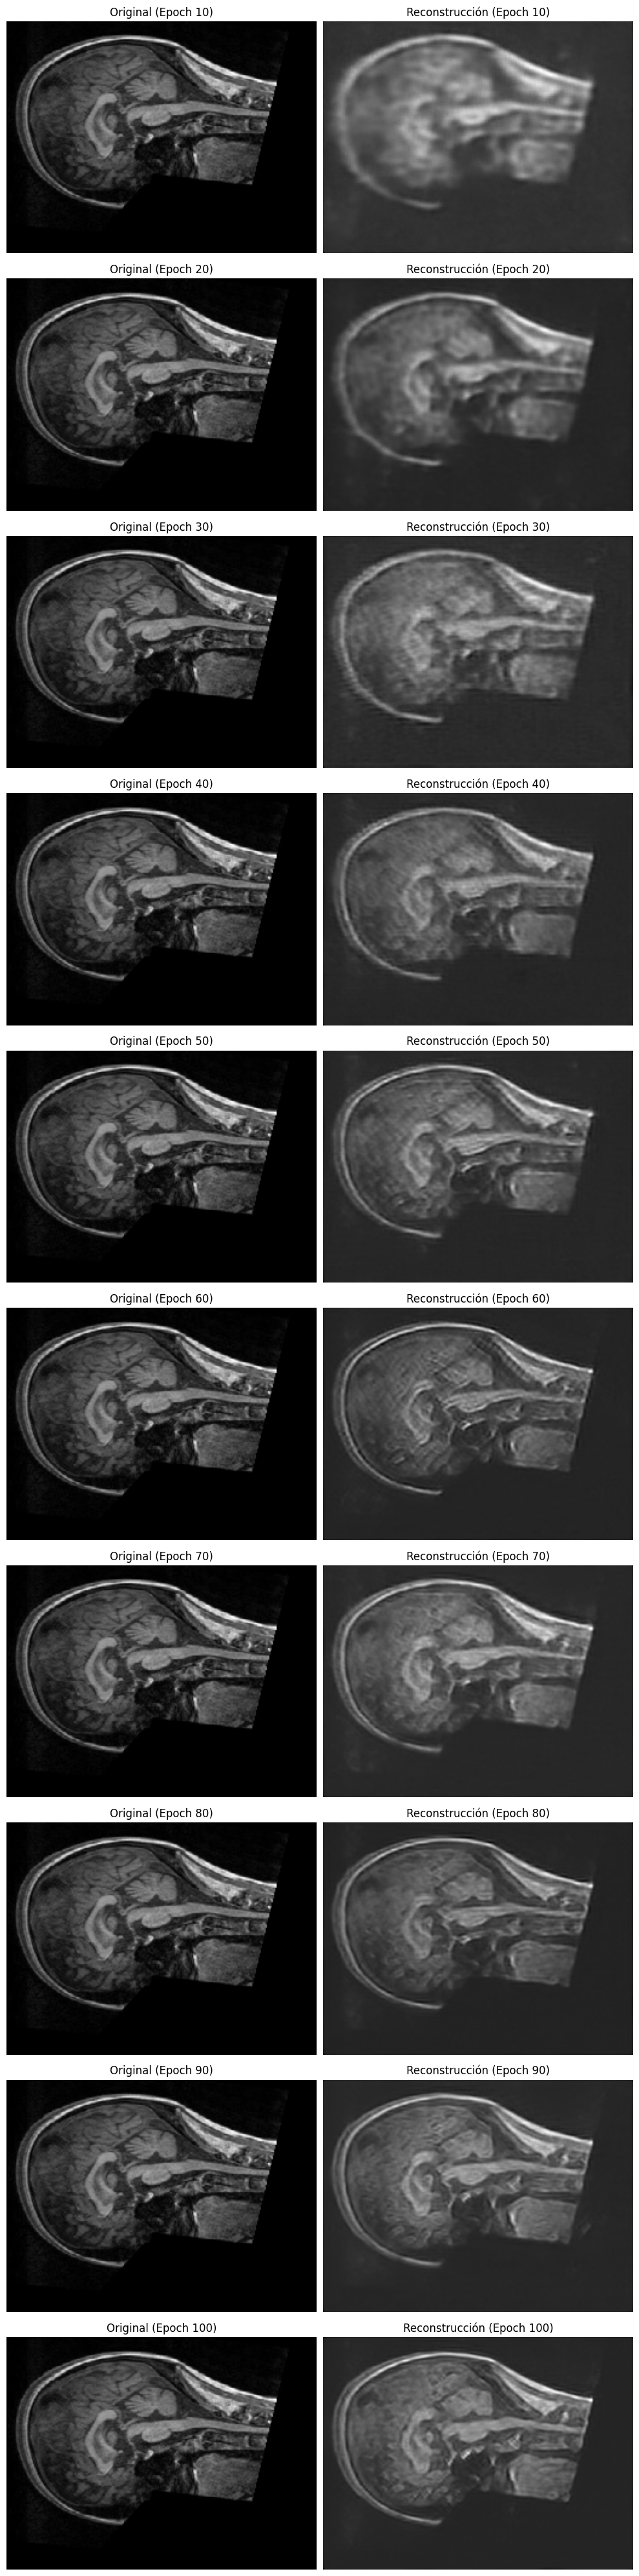

Modelo AutoencoderKL guardado exitosamente.


In [ ]:
import torch
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt

from generative.networks.nets import AutoencoderKL, PatchDiscriminator
from generative.losses import PatchAdversarialLoss, PerceptualLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 128, 256),
    latent_channels=3,
    num_res_blocks=2,
    attention_levels=(False, False, False),
    with_encoder_nonlocal_attn=False,
    with_decoder_nonlocal_attn=False,
).to(device)

try:
    import lpips
except ImportError:
    print("Instalando lpips...")
    !pip install -q lpips
    import lpips

perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex").to(device)
perceptual_weight = 0.001

discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    num_channels=64,
    in_channels=1,
    out_channels=1
).to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)
scaler_g = GradScaler()
scaler_d = GradScaler()

kl_weight = 1e-6
max_epochs = 100
val_interval = 10
autoencoder_warm_up_n_epochs = 10

epoch_recon_losses = []
val_recon_losses = []
intermediary_images = []
num_example_images = 4

print(f"Iniciando entrenamiento del Autoencoder en {device}...")

for epoch in range(max_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch+1}/{max_epochs}")

    for step, batch in progress_bar:
        images = batch["image"].to(device)

        optimizer_g.zero_grad(set_to_none=True)

        with autocast(device_type="cuda"):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)
            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())

            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch >= autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss
            else:
                generator_loss = torch.tensor(0.0)

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch >= autoencoder_warm_up_n_epochs:
            with autocast(device_type="cuda"):
                optimizer_d.zero_grad(set_to_none=True)

                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

            disc_epoch_loss += discriminator_loss.item()
            gen_epoch_loss += generator_loss.item()

        epoch_loss += recons_loss.item()

        progress_bar.set_postfix({
            "rec_loss": epoch_loss / (step + 1),
            "gen_loss": gen_epoch_loss / (step + 1),
            "disc_loss": disc_epoch_loss / (step + 1),
        })

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for _val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                with autocast(device_type="cuda"):
                    reconstruction, _, _ = autoencoderkl(images)
                    # Guardar la primera reconstrucción para visualizar
                    if _val_step == 1:
                        intermediary_images.append((images[0,0], reconstruction[0,0]))

                    recons_loss = F.l1_loss(images.float(), reconstruction.float())
                val_loss += recons_loss.item()

        val_loss /= _val_step
        print(f"\nEpoch {epoch + 1} val loss: {val_loss:.4f}")

del discriminator
del perceptual_loss
del optimizer_d
torch.cuda.empty_cache()

print("Entrenamiento completado. Visualizando resultados...")

if len(intermediary_images) > 0:
    plt.figure(figsize=(10, 4 * len(intermediary_images)))
    for i, (orig, recon) in enumerate(intermediary_images):
        plt.subplot(len(intermediary_images), 2, 2*i + 1)
        plt.imshow(orig.cpu(), cmap="gray")
        plt.title(f"Original (Epoch {(i+1)*val_interval})")
        plt.axis("off")

        plt.subplot(len(intermediary_images), 2, 2*i + 2)
        plt.imshow(recon.cpu(), cmap="gray")
        plt.title(f"Reconstrucción (Epoch {(i+1)*val_interval})")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

torch.save(autoencoderkl.state_dict(), os.path.join(root_dir, 'autoencoder_kl_final.pth'))

print("Modelo AutoencoderKL guardado exitosamente.")

Calculando factor de escala...

Iniciando entrenamiento del LDM por 200 épocas...


/tmp/ipython-input-1936134396.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1936134396.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/200:   0%|                                                           | 0/36 [00:00<?, ?it/s]/tmp/ipython-input-1936134396.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 40/200: 100%|█████████████████████████████████████| 36/36 [00:12<00:00,  2.78it/s, loss=0.197]
/tmp/ipython-input-1936134396.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1936134396.py:130: FutureWarning: `torch.cuda.amp.auto

Epoch 40 val loss: 0.2658


100%|██████████| 1000/1000 [00:27<00:00, 36.05it/s]


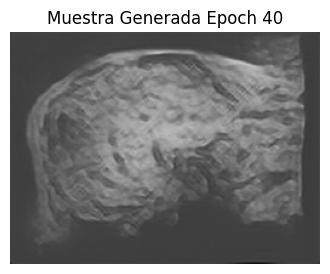

Epoch 80/200: 100%|█████████████████████████████████████| 36/36 [00:12<00:00,  2.77it/s, loss=0.201]


Epoch 80 val loss: 0.1775


100%|██████████| 1000/1000 [00:26<00:00, 37.08it/s]


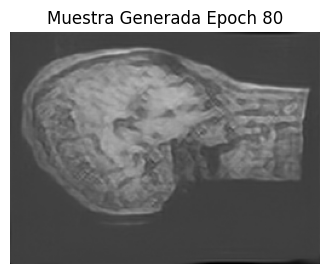

Epoch 120/200: 100%|█████████████████████████████████████| 36/36 [00:13<00:00,  2.76it/s, loss=0.22]


Epoch 120 val loss: 0.2212


100%|██████████| 1000/1000 [00:27<00:00, 36.68it/s]


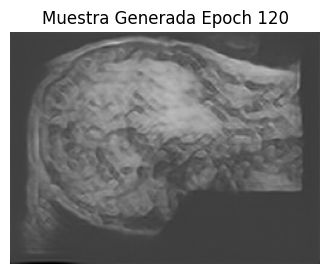

Epoch 160/200: 100%|████████████████████████████████████| 36/36 [00:13<00:00,  2.76it/s, loss=0.176]


Epoch 160 val loss: 0.2021


100%|██████████| 1000/1000 [00:27<00:00, 36.31it/s]


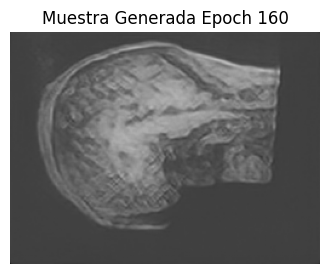

Epoch 200/200: 100%|████████████████████████████████████| 36/36 [00:13<00:00,  2.75it/s, loss=0.195]


Epoch 200 val loss: 0.1916


100%|██████████| 1000/1000 [00:27<00:00, 35.97it/s]


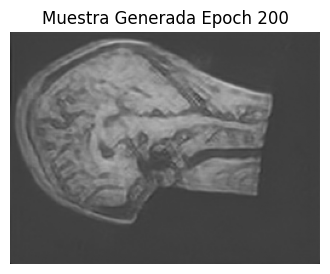

¡Entrenamiento finalizado!


In [ ]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt

from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler
from generative.inferers import LatentDiffusionInferer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(128, 256, 512),
    attention_levels=(False, True, True),
    num_head_channels=(0, 256, 512),
).to(device)

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    schedule="linear_beta",
    beta_start=0.0015,
    beta_end=0.0195
)

print("Calculando factor de escala...")
autoencoderkl.eval()

with torch.no_grad():
    check_data = next(iter(train_loader))
    images = check_data["image"].to(device)

    with autocast():
        # Codificar al espacio latente
        z = autoencoderkl.encode_stage_2_inputs(images)

    # Calcular factor: 1 / std(z)
    scale_factor = 1.0 / torch.std(z)

inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
scaler = GradScaler()
max_epochs = 200
val_interval = 40

epoch_losses = []
val_losses = []

print(f"\nIniciando entrenamiento del LDM por {max_epochs} épocas...")

for epoch in range(max_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100)
    progress_bar.set_description(f"Epoch {epoch+1}/{max_epochs}")

    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast():
            z_mu, z_sigma = autoencoderkl.encode(images)
            z = autoencoderkl.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
            ).long()
            noise_pred = inferer(
                inputs=images,
                diffusion_model=unet,
                noise=noise,
                timesteps=timesteps,
                autoencoder_model=autoencoderkl
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})

    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for _val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast():
                    z_mu, z_sigma = autoencoderkl.encode(images)
                    z = autoencoderkl.sampling(z_mu, z_sigma)
                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()

                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=unet,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoderkl,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()

        val_loss /= _val_step
        val_losses.append(val_loss)
        print(f"Epoch {epoch + 1} val loss: {val_loss:.4f}")

        latent_shape = (1, 3, int(192/4), int(256/4))

        z = torch.randn(latent_shape).to(device)

        scheduler.set_timesteps(num_inference_steps=1000)

        with autocast():
            decoded = inferer.sample(
                input_noise=z,
                diffusion_model=unet,
                scheduler=scheduler,
                autoencoder_model=autoencoderkl
            )

        plt.figure(figsize=(4, 4))
        plt.title(f"Muestra Generada Epoch {epoch+1}")
        plt.imshow(decoded[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.show()
torch.save(unet.state_dict(), os.path.join(root_dir, 'diffusion_unet_final.pth'))
print("¡Entrenamiento finalizado!")

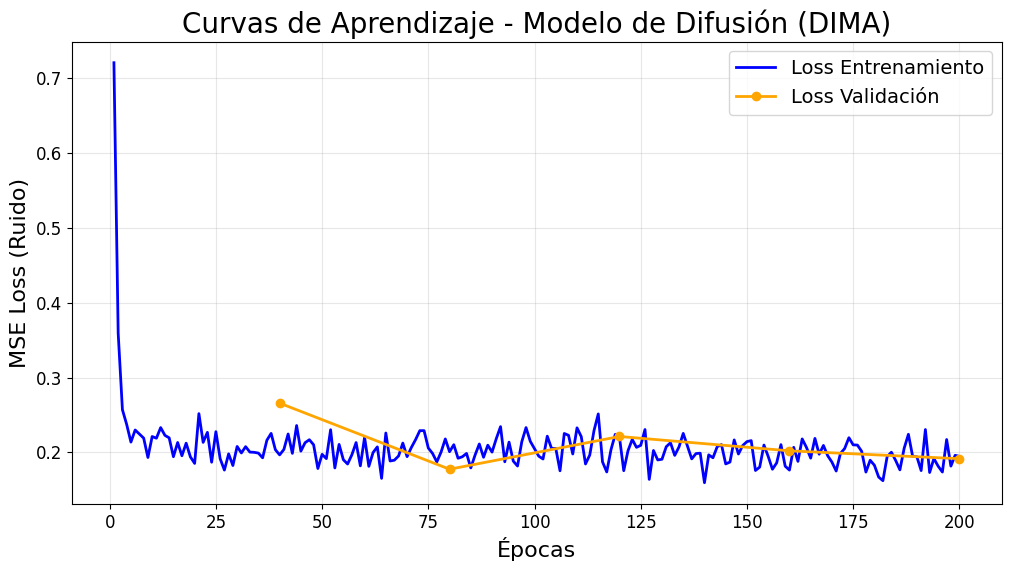

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title("Curvas de Aprendizaje - Modelo de Difusión (DIMA)", fontsize=20)
x_train = range(1, len(epoch_losses) + 1)
plt.plot(x_train, epoch_losses, linewidth=2.0, label="Loss Entrenamiento", color='blue')
x_val = range(val_interval, max_epochs + 1, val_interval)
plt.plot(x_val[:len(val_losses)], val_losses, linewidth=2.0, label="Loss Validación", color='orange', marker='o')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Épocas", fontsize=16)
plt.ylabel("MSE Loss (Ruido)", fontsize=16)
plt.legend(prop={"size": 14})
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import glob
from torch.utils.data import DataLoader, Dataset
from monai import transforms

output_dir = os.path.join(root_dir, 'synthetic_paired_dataset')
os.makedirs(os.path.join(output_dir, 'source'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'target'), exist_ok=True)
BATCH_SIZE = 4
VARIANTS_PER_IMAGE = 5
NOISE_LEVEL_RANGE = (0.35, 0.65)

class GenerationDataset(Dataset):
    def __init__(self, files, img_size=(192, 256)):
        self.files = files
        self.transforms = transforms.Compose([
            transforms.LoadImaged(keys=["image"], ensure_channel_first=True, image_only=True),
            transforms.Lambdad(keys=["image"], func=lambda x: x.mean(dim=0, keepdim=True) if x.shape[0] > 1 else x),
            transforms.Resized(keys=["image"], spatial_size=img_size),
            transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
            transforms.ToTensord(keys=["image"]),
        ])

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        return {"image": self.transforms({"image": path})["image"], "path": path}

clean_files = glob.glob(os.path.join(root_dir, 'Standard', view, "*.png"))

print(f"Encontradas {len(clean_files)} imágenes. Iniciando...")

gen_ds = GenerationDataset(clean_files)
gen_loader = DataLoader(gen_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

def dima_batch_injection(clean_batch, autoencoder, diffusion_model, scheduler, scale_factor, variant_idx):
    device = clean_batch.device
    curr_batch_size = clean_batch.shape[0]

    autoencoder.eval()
    diffusion_model.eval()

    with torch.no_grad():
        z_mu, z_sigma = autoencoder.encode(clean_batch)
        z_clean = autoencoder.sampling(z_mu, z_sigma) * scale_factor

        noise_levels = torch.rand(curr_batch_size, device=device) * (NOISE_LEVEL_RANGE[1] - NOISE_LEVEL_RANGE[0]) + NOISE_LEVEL_RANGE[0]
        start_steps = (noise_levels * scheduler.num_train_timesteps).long()

        noise = torch.randn_like(z_clean)
        z_noisy = scheduler.add_noise(original_samples=z_clean, noise=noise, timesteps=start_steps)

        current_sample = z_noisy
        max_step = start_steps.max().item()

        pbar_diff = tqdm(reversed(range(max_step)), total=max_step, desc=f"  Difusión Var {variant_idx+1}", leave=False)

        for t in pbar_diff:
            t_tensor = torch.full((curr_batch_size,), t, device=device).long()
            active_mask = (start_steps > t).float().view(-1, 1, 1, 1)

            if active_mask.sum() > 0:
                model_output = diffusion_model(current_sample, timesteps=t_tensor)
                step_output = scheduler.step(model_output, t, current_sample)

                prev = step_output[0] if isinstance(step_output, tuple) else step_output.prev_sample
                current_sample = active_mask * prev + (1 - active_mask) * current_sample
        current_sample = current_sample / scale_factor
        artifact_batch = autoencoder.decode(current_sample)

        return artifact_batch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
count = 0

for batch_idx, batch in enumerate(tqdm(gen_loader, desc="Lotes procesados")):
    clean_imgs = batch["image"].to(device)
    paths = batch["path"]

    for v in range(VARIANTS_PER_IMAGE):
        artifact_imgs = dima_batch_injection(
            clean_imgs, autoencoderkl, unet, scheduler, scale_factor, variant_idx=v
        )
        clean_np = clean_imgs.cpu().numpy()
        artifact_np = artifact_imgs.cpu().numpy()

        for i, path in enumerate(paths):
            filename = os.path.basename(path).rsplit('.', 1)[0]
            save_name = f"{filename}_v{v}.png"
            c_img = (clean_np[i, 0] * 255).clip(0, 255).astype(np.uint8)
            Image.fromarray(c_img).save(os.path.join(output_dir, 'target', save_name))
            a_img = (artifact_np[i, 0] * 255).clip(0, 255).astype(np.uint8)
            Image.fromarray(a_img).save(os.path.join(output_dir, 'source', save_name))

            count += 1

print(f"{count} imágenes generadas.")

Encontradas 148 imágenes. Iniciando...
🚀 Iniciando generación...


Lotes procesados:   0%|          | 0/37 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/622 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/627 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/540 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/615 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/590 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/514 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/636 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/601 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/625 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/622 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/641 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/564 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/580 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/623 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/609 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/546 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/499 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/450 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/568 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/571 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/550 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/640 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/558 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/586 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/602 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/623 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/565 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/637 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/617 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/609 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/632 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/617 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/636 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/629 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/596 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/596 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/609 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/559 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/544 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/576 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/648 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/579 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/481 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/601 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/622 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/641 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/591 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/555 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/513 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/620 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/626 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/611 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/585 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/597 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/630 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/602 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/555 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/602 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/588 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/627 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/613 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/619 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/647 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/613 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/632 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/550 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/572 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/586 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/603 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/614 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/492 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/515 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/601 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/543 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/420 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/585 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/623 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/572 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/516 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/559 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/620 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/442 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/625 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/542 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/585 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/544 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/643 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/513 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/593 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/553 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/607 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/500 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/648 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/577 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/632 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/642 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/584 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/610 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/631 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/622 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/595 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/573 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/537 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/638 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/586 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/635 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/638 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/540 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/595 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/605 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/517 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/579 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/594 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/630 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/620 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/616 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/503 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/641 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/647 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/639 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/646 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/587 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/568 [00:00<?, ?it/s]

  Difusión Var 4:   0%|          | 0/629 [00:00<?, ?it/s]

  Difusión Var 5:   0%|          | 0/619 [00:00<?, ?it/s]

  Difusión Var 1:   0%|          | 0/573 [00:00<?, ?it/s]

  Difusión Var 2:   0%|          | 0/645 [00:00<?, ?it/s]

  Difusión Var 3:   0%|          | 0/578 [00:00<?, ?it/s]

In [ ]:
import torch
import numpy as np
from tqdm.auto import tqdm
from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchmetrics.functional import structural_similarity_index_measure as ssim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# --- 1. CONFIGURACIÓN ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = '/content/drive/MyDrive/MR-ART Dataset'
dataset_path = os.path.join(root_dir, 'synthetic_paired_dataset')

# Aseguramos que los modelos estén en modo evaluación
autoencoderkl.eval()
unet.eval()

# Definición de MRE (Mean Relative Error)
def relative_error(pred, target, epsilon=1e-5):
    diff = torch.abs(pred - target)
    rel = diff / (torch.abs(target) + epsilon)
    return torch.mean(rel)

# Listas para guardar métricas
metrics_vae = {"psnr": [], "ssim": [], "mre": []}
metrics_dima = {"psnr": [], "ssim": [], "mre": []}

# --- 3. DATASET (Copied from U8ONewBBARxE) ---
class PairedDataset(Dataset):
    def __init__(self, root_dir, split='train'):
        self.source_dir = os.path.join(root_dir, 'source')
        self.target_dir = os.path.join(root_dir, 'target')
        self.files = sorted(os.listdir(self.source_dir))
        split_idx = int(len(self.files) * 0.9)
        if split == 'train': self.files = self.files[:split_idx]
        else: self.files = self.files[split_idx:]

    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        fname = self.files[idx]
        src_img = Image.open(os.path.join(self.source_dir, fname)).convert('L')
        tgt_img = Image.open(os.path.join(self.target_dir, fname)).convert('L')
        src = torch.from_numpy(np.array(src_img)).float() / 255.0
        tgt = torch.from_numpy(np.array(tgt_img)).float() / 255.0
        return {"source": src.unsqueeze(0), "target": tgt.unsqueeze(0)}

val_ds = PairedDataset(dataset_path, split='val')
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

print("📊 Evaluando Generador (VAE + DIMA)...")

# --- 2. BUCLE DE EVALUACIÓN ---
loader_to_use = val_loader

with torch.no_grad():
    for batch in tqdm(loader_to_use, desc="Calculando"):
        if isinstance(batch, dict):
            imgs = batch["target"].to(device)

        z_mu, z_sigma = autoencoderkl.encode(imgs)
        z = autoencoderkl.sampling(z_mu, z_sigma)
        recon_vae = autoencoderkl.decode(z)

        if 'dima_batch_injection' in globals():
            imgs_dima = dima_batch_injection(imgs, autoencoderkl, unet, scheduler, scale_factor, variant_idx=0)
        else:
            print("Warning: dima_batch_injection not found. Evaluation of DIMA might be incomplete.")

        imgs = torch.clamp(imgs, 0, 1)
        recon_vae = torch.clamp(recon_vae, 0, 1)
        imgs_dima = torch.clamp(imgs_dima, 0, 1)

        # --- CÁLCULO DE MÉTRICAS ---

        metrics_vae["psnr"].append(psnr(recon_vae, imgs, data_range=1.0).item())
        metrics_vae["ssim"].append(ssim(recon_vae, imgs, data_range=1.0).item())
        metrics_vae["mre"].append(relative_error(recon_vae, imgs).item())

        metrics_dima["psnr"].append(psnr(imgs_dima, imgs, data_range=1.0).item())
        metrics_dima["ssim"].append(ssim(imgs_dima, imgs, data_range=1.0).item())
        metrics_dima["mre"].append(relative_error(imgs_dima, imgs).item())

# --- 3. MOSTRAR RESULTADOS ---
print("\n" + "="*50)
print("     RESULTADOS DE EVALUACIÓN DEL GENERADOR")
print("="*50)

print(f"\n--- 1. CALIDAD DEL VAE (Compresión) ---")
print(f"Objetivo: Valores ALTOS")
print(f"PSNR: {np.mean(metrics_vae['psnr']):.2f} dB  (Ideal > 30)")
print(f"SSIM: {np.mean(metrics_vae['ssim']):.4f}     (Ideal > 0.90)")
print(f"MRE:  {np.mean(metrics_vae['mre']):.4f}     (Ideal < 0.05)")

print(f"\n--- 2. SEVERIDAD DE DIMA (Artefactos Generados) ---")
print(f"Objetivo: Valores MÁS BAJOS que VAE")
print(f"PSNR: {np.mean(metrics_dima['psnr']):.2f} dB")
print(f"SSIM: {np.mean(metrics_dima['ssim']):.4f}     (Rango útil: 0.60 - 0.85)")
print(f"MRE:  {np.mean(metrics_dima['mre']):.4f}     (Error relativo agregado)")
print("="*50)

# Visualización comparativa
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1); plt.imshow(imgs[0,0].cpu(), cmap='gray'); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(recon_vae[0,0].cpu(), cmap='gray'); plt.title(f"VAE (SSIM: {metrics_vae['ssim'][-1]:.2f})")
plt.subplot(1,3,3); plt.imshow(imgs_dima[0,0].cpu(), cmap='gray'); plt.title(f"DIMA (SSIM: {metrics_dima['ssim'][-1]:.2f})")
plt.show()